<a href="https://colab.research.google.com/github/rq-goh/ADALL_github/blob/main/Lab/ADALL_Preparing_and_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# ADALL – Preparing and Modelling
**Module:** AI-driven Analytics with Large Language Models (CDA1C03)  
**Block:** Preparing and Modelling (Sessions 1 & 2)  
**Focus:**  
- Use LLMs to support modelling objective and feature engineering  
- Build a simple baseline model, then compare additional tree-based models (RF, XGB)  



#Session 1


## 1. Setup: import libraries

you should already be familiar with many of these imports from earlier modules.


In [1]:
# Core libraries
import pandas as pd
import numpy as np
# Visualisation
import matplotlib.pyplot as plt
# Modelling and preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb


## 2. Load the dataset

> ** note:** Adjust the file path to match where you place the dataset in Colab or local environment.


In [2]:
# Example: Replace this with the raw URL of your GitHub file
github_raw_url = 'https://raw.githubusercontent.com/rq-goh/ADALL_github/main/laptop_prices_2024_sgd_TL.csv'
try:
    df = pd.read_csv(github_raw_url)
    print("Successfully loaded data from GitHub!")
    display(df.head())
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please ensure the URL is correct and the file format is compatible with `pd.read_csv`.")

Successfully loaded data from GitHub!


,Unnamed: 0,Brand,Model,CPU,GPU,RAM_GB,Storage_Type,Storage_GB,Touchscreen,Weight_kg,Screen_Size_inch,Discount_percent,Price_SGD,Brand_Discount,Member_Discount
0,0,Acer,Aspire 5,Intel i9-14900HK,NVIDIA RTX 4070,64,SSD,256,False,1.56,16.0,5.28,3207.60,80,160.38
1,1,Acer,Nitro 5,AMD Ryzen 9 8900HX,AMD Radeon 780M,32,SSD,1024,True,1.45,14.0,6.01,2568.40,80,179.79
2,2,Acer,Nitro 5,AMD Ryzen 5 8600H,NVIDIA RTX 4050,32,SSD,2048,False,1.34,14.0,6.56,2050.80,80,143.56
3,3,Acer,TravelMate P6,Intel Core Ultra 7 15500H,NVIDIA RTX 4060,16,SSD,4096,True,1.18,13.3,4.62,2477.59,80,173.43
4,4,Acer,Predator Helios 300,Intel i7-14800H,NVIDIA RTX 4070,8,SSD,1024,True,1.31,14.0,4.81,2626.40,80,183.85


In [3]:
df.columns

Index(['Unnamed: 0', 'Brand', 'Model', 'CPU', 'GPU', 'RAM_GB', 'Storage_Type',
       'Storage_GB', 'Touchscreen', 'Weight_kg', 'Screen_Size_inch',
       'Discount_percent', 'Price_SGD', 'Brand_Discount', 'Member_Discount'],
      dtype='object')

## 3. LLM-assisted problem framing

In this step, you use an LLM (ChatGPT, Gemini, etc.) to help **translate a business problem into a modelling objective**.

### 3.1 Business scenario (given to you)

The business problem is that a refurbished laptop store wants to understand and predict the retail price of its laptops based on their specifications.


### 3.2 Prompt to use with an LLM (for to try with ChatGPT etc.)

you can copy and adapt this prompt:

>You are an expert data scientist with extensive knowledge of tree-based models.
>  
> *Help me:* <br>
> *1. State a clear modelling objective for predicting laptop prices.*  
> *2. Identify the main stakeholders and how they will use the model.*  
> *3. Suggest at least three risks or pitfalls in using such a model in production.*

>Questions
>1. Based on the context and dataset info, how should i approach modelling objective? focus on problem framing aspects.
>2. What would be the most meaningful target?
>3. What would be most important metric for scoring?
>4. What are the top 3 most potentially important features?

### 3.3 Example  answer (short)

Below is a **short, simple version**, focused on **problem framing**, written for direct use in class or notes.

---

>## 1. Modelling objective
>
>**Predict the fair price of a laptop based on its hardware specifications.**
>
>The goal is to support consistent pricing and analysis, not to model promotions or marketing effects.

---

>## 2. Stakeholders and use
>
>* **Pricing or product teams**
  Use the model to check whether a laptop is priced reasonably given its specs.

>* **Procurement or analysts**
  Use predictions to compare suppliers or product variants.

>* **Students or data analysts**
  Use the model to practise tree-based modelling and interpretation.

---

## 3. Key risks in production

>1. **Target leakage**
   Discounts or rebates tied to price must not be used as features.

>2. **Fast hardware changes**
   New CPU generations can quickly make the model outdated.

>3. **Brand bias**
   Prices differ by brand and region, even for similar specs.

---

## Problem framing guidance

### Most meaningful target

**Original laptop price before any discounts.**

### Most important metric

**MAE (Mean Absolute Error)** because it is easy to explain in dollars.

### Top 3 likely important features

1. **CPU level (brand, series, model)**
2. **Storage size (GB)**
3. **Screen size or touchscreen**

---

If you want, I can turn this into a **one-slide objective + checklist** for students.




## 4. Quick data check

> you should confirm basic structure and identify the target variable.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        1000 non-null   int64  
 1   Brand             1000 non-null   object 
 2   Model             1000 non-null   object 
 3   CPU               1000 non-null   object 
 4   GPU               1000 non-null   object 
 5   RAM_GB            1000 non-null   int64  
 6   Storage_Type      1000 non-null   object 
 7   Storage_GB        1000 non-null   int64  
 8   Touchscreen       1000 non-null   bool   
 9   Weight_kg         1000 non-null   float64
 10  Screen_Size_inch  1000 non-null   float64
 11  Discount_percent  1000 non-null   float64
 12  Price_SGD         1000 non-null   float64
 13  Brand_Discount    1000 non-null   int64  
 14  Member_Discount   1000 non-null   float64
dtypes: bool(1), float64(5), int64(4), object(5)
memory usage: 110.5+ KB


> set up connection to LLM API

In [5]:
from google.colab import userdata
from openai import OpenAI

# Load key from Google Colab Secrets
api_key = userdata.get('OPENAI_API_KEY')

client = OpenAI(
    api_key=api_key,
)

In [6]:
#generate a preview of ten rows as text first, so that we can use it for sending to LLM API later.
data_preview = df.head(10).to_string()
print(data_preview)

   Unnamed: 0 Brand                Model                        CPU              GPU  RAM_GB Storage_Type  Storage_GB  Touchscreen  Weight_kg  Screen_Size_inch  Discount_percent  Price_SGD  Brand_Discount  Member_Discount
0           0  Acer             Aspire 5           Intel i9-14900HK  NVIDIA RTX 4070      64          SSD         256        False       1.56              16.0              5.28    3207.60              80           160.38
1           1  Acer              Nitro 5         AMD Ryzen 9 8900HX  AMD Radeon 780M      32          SSD        1024         True       1.45              14.0              6.01    2568.40              80           179.79
2           2  Acer              Nitro 5          AMD Ryzen 5 8600H  NVIDIA RTX 4050      32          SSD        2048        False       1.34              14.0              6.56    2050.80              80           143.56
3           3  Acer        TravelMate P6  Intel Core Ultra 7 15500H  NVIDIA RTX 4060      16          SSD       

> Do you spot any difference from the prompt above? There are additional guard-

In [7]:
#sending to LLM API
response = client.responses.create(
    model="gpt-5-mini",
    instructions="""
You are an expert data scientist with extensive knowledge of tree-based models.
Use ONLY the information inside the dataset profile text.
Do NOT invent correlations, columns, or values.
If something is not in the dataset profile, state 'Not shown in profile'.
Always justify recommendations using reasoning trace based ONLY on the dataset profile.
""",
    input=f"""Dataset info: {data_preview}\n
    Context:
    The business problem is that a refurbished laptop store wants to understand and predict the retail price of its laptops based on their specifications.\n
    Questions
    1. Based on the context and dataset info, how should i approach modelling objective? focus on problem framing aspects.
    2. What would be the most meaningful target?
    3. What would be most important metric for scoring?
    4. What are the top 3 most potentially important features?
    """)
print(response.output_text)

1) How to frame the modelling objective (approach)
- Problem type: supervised regression. Price_SGD is a continuous numeric column in the profile, so predict Price_SGD from the laptop specs.
- Modelling pipeline points to include (based only on columns shown):
  - Predictors: categorical specs (Brand, Model, CPU, GPU, Storage_Type) and numeric specs (RAM_GB, Storage_GB, Touchscreen boolean, Weight_kg, Screen_Size_inch, Discount_percent, Brand_Discount, Member_Discount).
  - Categorical handling: CPU, GPU and Model are high-cardinality/semantic categories in the profile (e.g., "Intel i9-14900HK", "NVIDIA RTX 4080", "Nitro 5"); encode with target encoding, frequency encoding or tree-based handling.
  - Numeric scaling/transform: consider log-transform of Price_SGD if errors are heteroscedastic (price spread visible in the sample).
  - Interactions / hierarchical effects: expect interactions (GPU × RAM_GB, CPU × GPU, Model × Brand). Model/Brand may capture bundled effects (same Model rows

In [8]:
df.columns

Index(['Unnamed: 0', 'Brand', 'Model', 'CPU', 'GPU', 'RAM_GB', 'Storage_Type',
       'Storage_GB', 'Touchscreen', 'Weight_kg', 'Screen_Size_inch',
       'Discount_percent', 'Price_SGD', 'Brand_Discount', 'Member_Discount'],
      dtype='object')

In [9]:
#replace Price_SGD with original price of all discounts and price
df['Price_SGD'] = ((
    df['Price_SGD'] + df['Member_Discount'] + df['Brand_Discount']
) / (
    1 - (df['Discount_percent'] / 100)
)).round(2)
df.drop(columns=['Brand_Discount', 'Member_Discount', 'Discount_percent'], inplace=True)
df.head()

,Unnamed: 0,Brand,Model,CPU,GPU,RAM_GB,Storage_Type,Storage_GB,Touchscreen,Weight_kg,Screen_Size_inch,Price_SGD
0,0,Acer,Aspire 5,Intel i9-14900HK,NVIDIA RTX 4070,64,SSD,256,False,1.56,16.0,3640.18
1,1,Acer,Nitro 5,AMD Ryzen 9 8900HX,AMD Radeon 780M,32,SSD,1024,True,1.45,14.0,3009.03
2,2,Acer,Nitro 5,AMD Ryzen 5 8600H,NVIDIA RTX 4050,32,SSD,2048,False,1.34,14.0,2434.03
3,3,Acer,TravelMate P6,Intel Core Ultra 7 15500H,NVIDIA RTX 4060,16,SSD,4096,True,1.18,13.3,2863.30
4,4,Acer,Predator Helios 300,Intel i7-14800H,NVIDIA RTX 4070,8,SSD,1024,True,1.31,14.0,3036.30


> Now lets create a payload of information for more in-depth analysis and recommendation by LLM.

In [10]:
import pandas as pd
import numpy as np
from io import StringIO

# ---------------------------
# Generate a full dataset profile
# ---------------------------

buffer = StringIO()

# dtypes
buffer.write("=== DTYPES ===\n")
buffer.write(df.dtypes.to_string())
buffer.write("\n\n")

# numeric describe
buffer.write("=== NUMERIC DESCRIBE ===\n")
buffer.write(df.describe().to_string())
buffer.write("\n\n")

# categorical describe
buffer.write("=== CATEGORICAL DESCRIBE ===\n")
try:
    buffer.write(df.describe(include='object').to_string())
except:
    buffer.write("No categorical columns")
buffer.write("\n\n")

# null summary
buffer.write("=== NULL SUMMARY ===\n")
null_summary = (
    df.isna().sum().to_frame("null_count")
    .assign(null_pct=lambda x: x["null_count"]/len(df))
)
buffer.write(null_summary.to_string())
buffer.write("\n\n")

# unique cardinality
buffer.write("=== UNIQUE VALUES PER COLUMN ===\n")
buffer.write(df.nunique().to_frame("unique_count").to_string())
buffer.write("\n\n")

# correlation matrix
buffer.write("=== CORRELATIONS (NUMERIC ONLY) ===\n")
buffer.write(df.corr(numeric_only=True).round(3).to_string())
buffer.write("\n\n")

# value counts for categoricals
buffer.write("=== VALUE COUNTS (TOP 20 PER CATEGORICAL COLUMN) ===\n")
cat_cols = df.select_dtypes(include='object').columns
if len(cat_cols) > 0:
    for col in cat_cols:
        buffer.write(f"\nColumn: {col}\n")
        vc = df[col].value_counts().head(20)
        buffer.write(vc.to_string())
        buffer.write("\n")
else:
    buffer.write("No categorical columns\n")
buffer.write("\n")

# --------- FIXED OUTLIER COMPUTATION (NO BOOLEANS) ---------
buffer.write("=== OUTLIER SUMMARY (IQR METHOD) ===\n")
num_cols = df.select_dtypes(include=['number']).columns  # exclude booleans
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df[num_cols] < (Q1 - 1.5*IQR)) | (df[num_cols] > (Q3 + 1.5*IQR))).sum()
buffer.write(outliers.to_string())
buffer.write("\n\n")

# leakage scan: columns with all unique values
buffer.write("=== POSSIBLE LEAKAGE COLUMNS (UNIQUE FOR EACH ROW) ===\n")
leak_cols = df.columns[df.nunique() == len(df)]
buffer.write(str(list(leak_cols)))
buffer.write("\n\n")

# shape, duplicates, constant cols
buffer.write("=== SHAPE / DUPLICATES / CONSTANT COLUMNS ===\n")
dup_count = df.duplicated().sum()
constant_cols = df.columns[df.nunique() == 1].tolist()
buffer.write(f"Rows: {len(df)}, Columns: {df.shape[1]}\n")
buffer.write(f"Duplicate rows: {dup_count}\n")
buffer.write(f"Constant columns: {constant_cols}\n\n")

# Final text
payload_text = buffer.getvalue()

print(payload_text)


=== DTYPES ===
Unnamed: 0            int64
Brand                object
Model                object
CPU                  object
GPU                  object
RAM_GB                int64
Storage_Type         object
Storage_GB            int64
Touchscreen            bool
Weight_kg           float64
Screen_Size_inch    float64
Price_SGD           float64

=== NUMERIC DESCRIBE ===
        Unnamed: 0       RAM_GB   Storage_GB    Weight_kg  Screen_Size_inch    Price_SGD
count  1000.000000  1000.000000  1000.000000  1000.000000       1000.000000  1000.000000
mean    499.500000    53.128000  1505.024000     2.036560         15.645700  3048.100040
std     288.819436    44.413288  1380.203919     0.746477          1.759846   784.036179
min       0.000000     8.000000   256.000000     1.000000         13.300000  1594.700000
25%     249.750000    16.000000   512.000000     1.340000         14.000000  2400.700000
50%     499.500000    32.000000  1024.000000     1.970000         15.600000  3000.430000


## 5. Important note before we look at the advanced checks

The checks in this section are **not rules**.
They are **warnings and suggestions**.

Nothing here should be dropped automatically just because it appears in a list.
You must always apply **domain knowledge and business context** before taking action.

Think of these checks as:

> “Things you should stop and think about”, not
> “Things you must remove”.

---

### 1. Correlations: a signal, not a verdict

```python
df.corr(numeric_only=True)
```

This tells you whether two numeric features move together.

What this **does not** mean:

* High correlation does **not** automatically mean “drop a column”.
* Low correlation does **not** mean “the feature is useless”.

Why domain knowledge matters:

* Two features can be correlated but still important:

  * Example: screen size and weight both reflect physical design.
* Removing one blindly may remove useful meaning.

Correct use:

* Use correlations to **flag pairs to review**.
* Decide what to drop only after understanding:

  * how the data was generated
  * which feature is more stable in the real world

---

### 2. Outlier detection: observation, not removal

```python
((df[num_cols] < (Q1 - 1.5*IQR)) | (df[num_cols] > (Q3 + 1.5*IQR))).sum()
```

This identifies values far from the typical range.

What this **does not** mean:

* An outlier is **not automatically an error**.
* Outliers are often **valid and meaningful**.

Why domain knowledge matters:

* Expensive items may legitimately be rare.
* Extreme values may represent:

  * premium products
  * edge cases that matter to the business

Correct use:

* Treat this as a **prompt for inspection**.
* Ask:

  * Is this value realistic?
  * Does it represent a real scenario we care about?

---

### 3. Possible leakage scan: strongest warning, still not automatic

```python
df.columns[df.nunique() == len(df)]
```

These are columns where every row has a unique value.

Why this is flagged:

* Fully unique columns often behave like:

  * IDs
  * reference numbers
  * timestamps

Why domain knowledge is critical:

* Some unique identifiers are harmless.
* Others encode information too close to the target.

Correct use:

* Always ask:

  * Was this column created before or after the target was known?
  * Would this column exist at prediction time?

This check highlights **risk**, not guilt.

---

### 4. High-cardinality categories: modelling trade-offs

```python
df.nunique()
```

Columns with many distinct values create modelling challenges.

What this **does not** mean:

* High cardinality does **not mean “drop it”**.
* It often means “handle carefully”.

Why domain knowledge matters:

* Model names, product codes, or locations can be highly informative.
* Dropping them may hurt performance dramatically.

Correct use:

* Decide based on:

  * business meaning
  * stability over time
  * whether rare categories are important

---

### 5. Constant columns: the only near-safe drop

```python
df.columns[df.nunique() == 1]
```

Constant columns truly carry no information.

Even here:

* Double-check that the constant is not due to:

  * limited sample
  * incomplete data collection

This is the **only** case where dropping is usually safe.

---

### Final takeaway for you

These advanced checks are:

* **diagnostic tools**
* **early warning systems**
* **questions generators**

They are **not filters to apply blindly**.

In real projects, the most damaging mistakes come from:

> automatically dropping features without understanding why they exist.

Always decide using:

* business context
* data generation process
* what will realistically be available at prediction time

The code helps you **notice**.
You are responsible for the **decision**.


In [11]:
response = client.responses.create(
    model="gpt-5-mini",
    instructions="""
You are an expert data scientist with extensive knowledge of tree-based models.
Always justify recommendations using reasoning trace based ONLY on the dataset profile.
""",
    input=f"""
Dataset info: {payload_text}\n
Questions:\n
1. Based on the dataset profile, what data quality issues should be resolved before modelling?
Provide a priority list and justify each item. \n
2. Which columns appear redundant, correlated, or likely to cause leakage?
Explain why each is problematic. \n
Next: Provide a python script to handle the identified issues.
Define one helper function for each issue.
Then define a wrapper function that calls these helper with true false option as user choice
Provide a single line of code to run the overall wrapper function.
Do not encode categorical columns or model first.

""")

print(response.output_text)


Below I (1) list the data-quality issues to address (priority order) with direct justification drawn only from the provided dataset profile, (2) call out columns that are redundant/correlated/likely leakage, and (3) provide a Python preprocessing script with one helper function per issue and a wrapper that conditionally applies them (plus a single-line example of running the wrapper). I do not perform any categorical encoding or modeling in the script.

1) Priority list of data-quality issues to resolve (with justification from the profile)

Priority 1 — Drop the unique row identifier / index-like column(s)
- Column: Unnamed: 0
- Why: Unique for each row (unique_count == 1000 and explicit "POSSIBLE LEAKAGE COLUMNS"). A column unique per row can leak information (it directly identifies samples) and will not help generalizable modeling. The profile shows Unnamed: 0 is an index-like column and is likely an artifact — drop it before modeling.

Priority 2 — Remove constant column(s)
- Colum

In [12]:
# ---------------------------
# One of the possible response from GPT.
# What are the differences with yours?
# How would you improve earlier prompt?
# ---------------------------

# Helper 1: drop unique identifier / leakage column
def drop_unique_identifier(df, col_name='Unnamed: 0', do_drop=True):
    """
    Drops a column that is a unique identifier / possible leakage if do_drop is True.
    Uses profile evidence: Unnamed: 0 has unique_count == nrows.
    Returns (df_modified, info_dict).
    """
    df = df.copy()
    info = {'dropped': [], 'skipped': []}
    if col_name in df.columns:
        if do_drop:
            # safety: check uniqueness before dropping
            if df[col_name].nunique() == len(df):
                df = df.drop(columns=[col_name])
                info['dropped'].append(col_name)
            else:
                # not unique, still allow drop if user insisted
                df = df.drop(columns=[col_name])
                info['dropped'].append(col_name + ' (not unique)')
        else:
            info['skipped'].append(col_name)
    else:
        info['skipped'].append(col_name + ' (not present)')
    return df, info

# Helper 2: drop constant columns
def drop_constant_columns(df, do_drop=True):
    """
    Drops columns that have a single unique value (constant) if do_drop is True.
    Based on profile: Storage_Type is constant (unique == 1).
    Returns (df_modified, info_dict).
    """
    df = df.copy()
    info = {'dropped': [], 'skipped': []}
    const_cols = [c for c in df.columns if df[c].nunique() <= 1]
    if do_drop:
        if const_cols:
            df = df.drop(columns=const_cols)
            info['dropped'].extend(const_cols)
        else:
            info['skipped'].append('no_constant_columns_found')
    else:
        info['skipped'].extend(const_cols)
    return df, info

# Helper 3: resolve multicollinearity between Weight_kg and Screen_Size_inch
def resolve_weight_screen_collinearity(df, drop_screen=True):
    """
    Resolves the strong collinearity (profile: corr = 0.924) between Weight_kg and Screen_Size_inch.
    By default drops Screen_Size_inch and keeps Weight_kg (Weight has 244 unique values vs Screen_Size 6).
    Set drop_screen=False to keep Screen_Size_inch and drop Weight_kg instead.
    Returns (df_modified, info_dict).
    """
    df = df.copy()
    info = {'dropped': [], 'kept': []}
    w_col = 'Weight_kg'
    s_col = 'Screen_Size_inch'
    # Only act if both exist
    if w_col in df.columns and s_col in df.columns:
        if drop_screen:
            df = df.drop(columns=[s_col])
            info['dropped'].append(s_col)
            info['kept'].append(w_col)
        else:
            df = df.drop(columns=[w_col])
            info['dropped'].append(w_col)
            info['kept'].append(s_col)
    else:
        # if one is missing, note what remains
        if w_col in df.columns:
            info['kept'].append(w_col)
        if s_col in df.columns:
            info['kept'].append(s_col)
    return df, info

# Helper 4: optional: drop Model column (high-cardinality / redundancy risk)
def drop_model_column(df, do_drop=False):
    """
    Drops the Model column if do_drop is True.
    Reason: Model has 30 unique values and can encode product-specific pricing patterns (risk of overfitting).
    Caller can choose to drop or keep.
    Returns (df_modified, info_dict).
    """
    df = df.copy()
    info = {'dropped': [], 'skipped': []}
    col = 'Model'
    if col in df.columns:
        if do_drop:
            df = df.drop(columns=[col])
            info['dropped'].append(col)
        else:
            info['skipped'].append(col)
    else:
        info['skipped'].append(col + ' (not present)')
    return df, info

# Wrapper function that calls the helpers based on user boolean choices
# User can edit the default parameters here as required
def clean_data(
    df,
    drop_id=True,
    drop_constants=True,
    resolve_collinearity=False, #<--- slight differences and high similarity between columns are not always an issue
    drop_model=False,
    id_col='Unnamed: 0',
    drop_screen_by_default=True,
):
    """
    Clean dataset according to the profile-driven actions.
    Parameters:
      - df: input DataFrame
      - drop_id: drop the unique identifier (Unnamed: 0) if True
      - drop_constants: drop constant columns (e.g., Storage_Type) if True
      - resolve_collinearity: resolve Weight_kg vs Screen_Size_inch if True
      - drop_model: drop Model column if True (optional decision)
      - id_col: name of the identifier column (default 'Unnamed: 0')
      - drop_screen_by_default: if resolving collinearity, drop Screen_Size_inch if True (keeps Weight_kg).
    Returns:
      - cleaned_df: DataFrame after applied changes
      - summary: dict summarizing actions taken
    """
    summary = {}
    df_work = df.copy()
    # 1. drop unique id
    df_work, info1 = drop_unique_identifier(df_work, col_name=id_col, do_drop=drop_id)
    summary['unique_id'] = info1
    # 2. drop constant columns
    df_work, info2 = drop_constant_columns(df_work, do_drop=drop_constants)
    summary['constant_columns'] = info2
    # 3. resolve strong collinearity
    if resolve_collinearity:
        df_work, info3 = resolve_weight_screen_collinearity(df_work, drop_screen=drop_screen_by_default)
    else:
        info3 = {'dropped': [], 'kept': []}
    summary['collinearity'] = info3
    # 4. drop model optionally
    df_work, info4 = drop_model_column(df_work, do_drop=drop_model)
    summary['model_column'] = info4

    return df_work, summary

# Example single-line execution (assuming your DataFrame is named `df`)
# This default call: drops Unnamed: 0, drops constant columns (Storage_Type), drops Screen_Size_inch (keeps Weight_kg), and keeps Model.
# To drop Model as well, set drop_model=True.
cleaned_df, cleaning_summary = clean_data(df)

In [13]:
cleaned_df

,Brand,Model,CPU,GPU,RAM_GB,Storage_GB,Touchscreen,Weight_kg,Screen_Size_inch,Price_SGD
0,Acer,Aspire 5,Intel i9-14900HK,NVIDIA RTX 4070,64,256,False,1.56,16.0,3640.18
1,Acer,Nitro 5,AMD Ryzen 9 8900HX,AMD Radeon 780M,32,1024,True,1.45,14.0,3009.03
2,Acer,Nitro 5,AMD Ryzen 5 8600H,NVIDIA RTX 4050,32,2048,False,1.34,14.0,2434.03
3,Acer,TravelMate P6,Intel Core Ultra 7 15500H,NVIDIA RTX 4060,16,4096,True,1.18,13.3,2863.30
4,Acer,Predator Helios 300,Intel i7-14800H,NVIDIA RTX 4070,8,1024,True,1.31,14.0,3036.30
...,...,...,...,...,...,...,...,...,...,...
995,Microsoft,Surface Go 3,Intel i7-14800H,NVIDIA RTX 4070,32,512,False,1.15,13.3,3172.97
996,Microsoft,Surface Go 3,Intel i9-14900HK,NVIDIA RTX 4070,8,256,True,2.46,15.6,3279.22
997,Microsoft,Surface Book 3,AMD Ryzen 5 8600H,AMD Radeon 680M,64,4096,True,3.13,18.4,2801.12
998,Microsoft,Surface Laptop 5,Intel i9-14900HK,NVIDIA RTX 4080,32,512,True,2.12,16.0,3874.74


In [14]:
cleaning_summary

{'unique_id': {'dropped': ['Unnamed: 0'], 'skipped': []},
 'constant_columns': {'dropped': ['Storage_Type'], 'skipped': []},
 'collinearity': {'dropped': [], 'kept': []},
 'model_column': {'dropped': [], 'skipped': ['Model']}}

<Axes: >

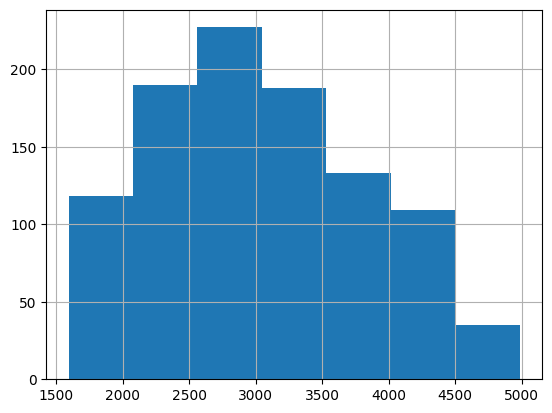

In [15]:
cleaned_df['Price_SGD'].hist(bins=7)

#Session 2


## 6. Define target and features

Here we formalise the modelling objective from code point of view.


In [16]:
X = cleaned_df.drop(columns=['Price_SGD'])
y = cleaned_df['Price_SGD']


## 7. Baseline modelling: train/test split to create a holdout set

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#define cat and num columns
cat_columns=X.select_dtypes(include='object').columns
num_columns=X.select_dtypes(exclude='object').columns

### 7.0 Why a holdout set?

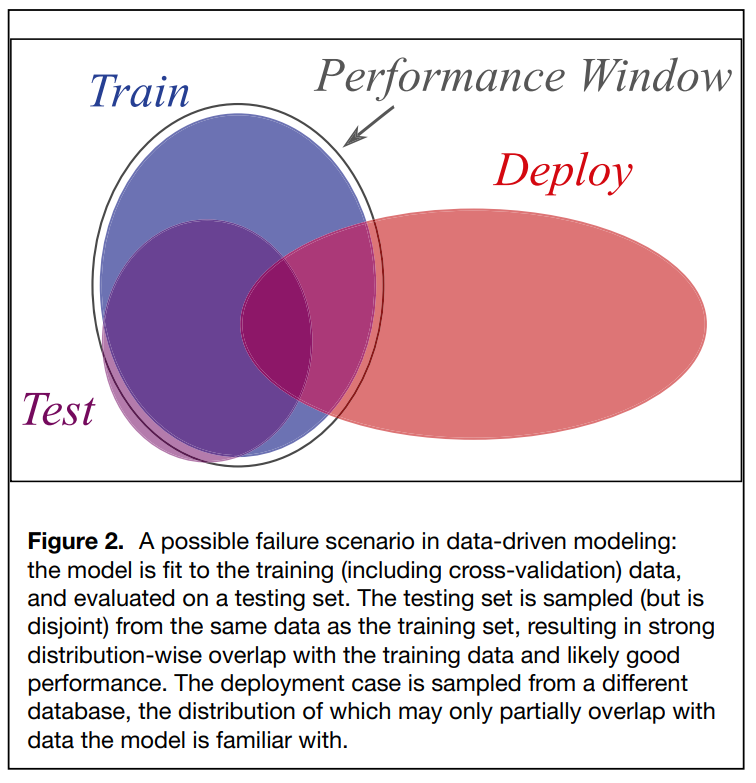

### How to read this diagram and why it matters

This diagram shows **three different data regions** that a model encounters in practice: training, testing, and deployment.

### Train (blue)

Training data is what you use to fit the model.

* The model sees this data many times.
* It becomes very familiar with this region.
* Performance here is usually high.

---

### Test (purple)

The test set is mostly drawn from the same distribution as training data.

Important detail:

* There is a **small part of the test set that does NOT overlap** with the training set.
* This small non-overlapping area checks whether the model can handle *slightly new cases*.

However:

> A good test score mainly means
> “the model understands this dataset well”.

It does **not** guarantee real-world success.

---

### Deploy (red)

Deployment data represents real usage.

Notice:

* Most of the deploy region does **not overlap** with training or testing.
* Only a small portion is familiar to the model.

This is where many models fail:

* accuracy drops,
* predictions become unreliable,
* yet the model still outputs numbers.

Models do not know when they are outside their comfort zone.

---

## What the “performance window” means

The performance window marks:

* the region where the model behaves reliably.

Inside the window:

* predictions are meaningful.

Outside the window:

* predictions may look confident but are not trustworthy.

---

## Why a test set is not enough

A test set:

* checks overfitting,
* includes a small unseen region.

But it still comes from the **same data source** and went through the **same pipeline**.

So it cannot answer:

> “Will this model still work after deployment?”

---

## Why you need a holdout set

A holdout set is intended to simulate:

* data collected from a different time, system, or context,
* and closer to real deployment data.

It helps:

* reduce surprises,
* reveal weaknesses earlier.

Think of it as:

> practising under realistic conditions, not repeating the same exam.

---

## Where reinforcement learning fits in

Supervised learning assumes:

* patterns stay stable over time.

Deployment breaks this assumption.

Reinforcement learning helps by:

* learning from feedback after deployment,
* adapting when behaviour changes,
* gradually adjusting the model to new conditions.

Simple view:

* supervised learning prepares the model,
* reinforcement learning helps it adapt in the real world.

---

## Why encoders must handle unknown categories

Look again at the deploy (red) region.

Deployment introduces **new values**, especially for categorical features such as:

* brands,
* product models,
* category labels.

These values may not exist in training or test data.

---

## What happens without `handle_unknown`

If an encoder only knows training categories:

* unseen categories can cause errors,
* or crash the pipeline at deployment.

This is a common production failure.

---

## What `handle_unknown` solves

`handle_unknown` tells the encoder:

> “What should I do when I see a category I have never seen before?”

Typical behaviour:

* ignore the unknown category,
* map it to a default or fallback value.

This does not improve model intelligence.
It improves **system robustness**.

---

## Simple example

Training data:

```
Brand = [Dell, HP, Lenovo]
```

Deployment data:

```
Brand = [Dell, HP, Asus]
```

Without `handle_unknown`:

* `Asus` causes an error.

With `handle_unknown`:

* the pipeline continues,
* the model still produces a prediction.

---

## Final takeaway

* Training teaches the model.
* Test data checks limited generalisation, including a small unseen region.
* Holdout data approximates real deployment.
* Reinforcement learning helps models adapt after deployment.
* `handle_unknown` prevents pipelines from breaking when reality changes.

If you remember one line:

> A model may fail silently, but your pipeline should never fail unexpectedly.



### 7.1 Basic preprocessing pipeline

>We use a simple `ColumnTransformer` with option of: <br>
>- `OneHotEncoder` OR `OrdinalEncoder` for categorical features  
>- `StandardScaler` for numeric features (but not necessary for Tree-based model)
><br>
>This is a good default that you already know from prior modules.


In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
#categorical_transformer = OneHotEncoder(handle_unknown="ignore")
categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
#numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer([
        ("cat", categorical_transformer, cat_columns)
    ],remainder='passthrough')



## 8. Baseline model: Decision Tree Regressor

We start with a single decision tree as a simple baseline.  
We will use this later to compare against Random Forest and XGBoost.


In [19]:
#setup a results df to hold training and test scores
#at this point, you should already decide what scoring metric you going to use
#regression: r2, mae, rmse, mape
results = pd.DataFrame(['cv_mae_test', 'cv_std_test', 'cv_mae_train', 'cv_std_train','best parameter'])

In [20]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, ShuffleSplit

In [21]:
#define model
regressor = DecisionTreeRegressor(random_state=42)
#create pipeline
pipe = Pipeline([
   ('preprocessor',preprocessor),
   ('regressor',regressor)
])
#define cv, to reduce effect or a 'lucky' or 'unlucky' split
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

#define a small parameter grid. This is enough for a first pass.
#do not scan too many parameters because tree models can overfit easily,
#and the goal here is to test the process, not to chase the perfect score.

#as the proposed engineered features may not be perfectly tuned yet,
#there is no benefit in running a large or expensive grid search.
#A small grid helps you compare model behaviour without wasting time.
#The max depth here represents an underfitted, 2 attempts at balanced,
#and an overfitted tree.

param_grid = {
  'regressor__max_depth':[1, 5, 10, None],
  'regressor__min_samples_split':[2,5,10]
}
#we will ask algo to score every single para combination
#None and 2, None and 5, None and 10, 1 and 2, .....
grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring='neg_median_absolute_error',n_jobs=-1)
grid_search.fit(X_train, y_train)
#run cross validation
scores_train = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=cv, scoring='neg_median_absolute_error')
scores_test = cross_val_score(grid_search.best_estimator_, X_test, y_test, cv=cv, scoring='neg_median_absolute_error')
mean_score_test = scores_test.mean()
std_score_test = scores_test.std()
mean_score_train = scores_train.mean()
std_score_train = scores_train.std()
#good practice to define new scores as new df, then concat to existing results df
results_in = pd.DataFrame([mean_score_test,
                           std_score_test,
                           mean_score_train,
                           std_score_train,
                           grid_search.best_params_],
                         columns=['Baseline DTR'])
results = pd.concat([results, results_in], axis=1)
display(results)

,0,Baseline DTR
0,cv_mae_test,-184.701587
1,cv_std_test,41.375452
2,cv_mae_train,-110.860528
3,cv_std_train,11.890084
4,best parameter,"{'regressor__max_depth': 10, 'regressor__min_s..."


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


---

**What does an MAE of 100 actually mean?**
Because MAE is an average across all laptops, it does not mean every laptop prediction is off by 100. Instead, it means that **on average**, the predicted price of a laptop differs from its true price by about 100.

However, this single number hides important variation:

* some laptops will have very small errors,
* others may have much larger errors.

Next week, you will move beyond this average and examine **individual prediction errors**. This process is called **error analysis**, where the focus shifts from “How good is the model overall?” to “Where and why does the model make mistakes?”

---

**Why do we use `neg_mean_absolute_error` in GridSearchCV?**
GridSearchCV is designed to **maximise** a score.
But MAE is a **loss**, where **smaller is better**.

To fit this maximisation framework, scikit-learn:

* multiplies MAE by −1,
* and exposes it as `neg_mean_absolute_error`.

This means:

* a *less negative* value (for example −90) is better than a *more negative* value (for example −120),
* and the “best” model returned by GridSearchCV is the one with the **smallest actual MAE**.

Important clarification:

* the model is **not** optimising a negative error in reality,
* the negative sign is purely a technical requirement for consistent scoring.

---

## 9. LLM-assisted feature engineering brainstorm




Now that a baseline model exists, we want you to **think about better features**, not just accept the raw columns.

### 9.1 Feature engineering prompt (for you)

Ask you to use an LLM with a prompt like:

> *I am predicting laptop price (`Price_SGD`) from features like brand, CPU description, RAM, storage, screen size, weight, touchscreen, and brand discount.*  
> *Suggest at least 5 engineered features that might improve predictive performance and are meaningful to the business. For each feature, explain:*  
> *- Why it might influence price.*  
> *- How to compute it from existing columns.*  
> *- Any risks or drawbacks in using it.*

### 9.2 Example  answer (short list)

Possible engineered features (examples):  

1. **`Storage_TB`** – convert `Storage_GB` to TB for easier interpretation.  
2. **`Is_Premium_Brand`** – binary flag for brands in a premium list (e.g. Apple).  
3. **`Performance_Score`** – numeric score combining CPU series and RAM.  
4. **`Portability_Score`** – function of `Weight_kg` and `Screen_Size_inch`.  
5. **`Discounted_Price_SGD`** – derived from `Price_SGD` and `Brand_Discount` if available.

> ** note:** Encourage you to check if the engineered feature is actually computable from the columns they have, and to avoid target leakage (do not use future or post-price information).



### 9.3 Implement a small set of engineered features

Here we implement a few simple, safe features as an example.


In [22]:
# Collect categorical columns and their unique values as a single string
cat_summary = []

for col in cat_columns:
    uniques = X_train[col].unique()
    cat_summary.append(f"{col}: {list(uniques)}")

cat_summary_text = "\n".join(cat_summary)
cat_summary_text

"Brand: ['Acer', 'HP', 'Lenovo', 'Microsoft', 'Dell', 'Asus']\nModel: ['TravelMate P6', 'Pavilion 15', 'Legion 5', 'Envy 13', 'Surface Laptop 5', 'Aspire 5', 'Inspiron 15', 'IdeaPad 5', 'Surface Book 3', 'ThinkBook 14s', 'ROG Zephyrus G15', 'Yoga Slim 7', 'ExpertBook B9', 'ZenBook 14', 'Surface Pro 8', 'Predator Helios 300', 'Surface Laptop Studio', 'Nitro 5', 'Omen 15', 'Surface Go 3', 'XPS 15', 'VivoBook S15', 'XPS 13', 'Swift 3', 'Latitude 7420', 'TUF Gaming F15', 'Alienware M15', 'EliteBook 840', 'Spectre x360', 'ThinkPad X1 Carbon']\nCPU: ['Intel Core Ultra 7 15500H', 'Intel i5-14600H', 'Intel i7-14700H', 'Intel i9-14900HK', 'Intel i5-14500H', 'Intel i7-14800H', 'AMD Ryzen 7 8800H', 'AMD Ryzen 9 8900HX', 'AMD Ryzen 5 8600H', 'Intel Core Ultra 9 15700H']\nGPU: ['NVIDIA RTX 4070', 'NVIDIA RTX 4050', 'NVIDIA RTX 4060', 'NVIDIA RTX 3050', 'Intel Arc A750M', 'Intel Iris Xe', 'NVIDIA RTX 4080', 'AMD Radeon 780M', 'AMD Radeon 680M']"

In [23]:
response = client.responses.create(
    model="gpt-5-mini",
    instructions="""
You are an AI with extensive knowledge of tree-based models, do not provide anything else besides what is requested.
""",
    input=f"""
Categorical columns name: unique names of values\n
{cat_summary_text}\n
Next: Output ONLY valid Python dictionaries with latest retail singapore dollar retail price,
One dictionary per column
""")

print(response.output_text)


Brand = {
    'Acer': 1100,
    'HP': 1300,
    'Lenovo': 1200,
    'Microsoft': 2200,
    'Dell': 1400,
    'Asus': 1300
}
Model = {
    'TravelMate P6': 1500,
    'Pavilion 15': 1100,
    'Legion 5': 1800,
    'Envy 13': 1400,
    'Surface Laptop 5': 2000,
    'Aspire 5': 700,
    'Inspiron 15': 900,
    'IdeaPad 5': 900,
    'Surface Book 3': 2500,
    'ThinkBook 14s': 1400,
    'ROG Zephyrus G15': 2500,
    'Yoga Slim 7': 1300,
    'ExpertBook B9': 2200,
    'ZenBook 14': 1500,
    'Surface Pro 8': 1500,
    'Predator Helios 300': 2000,
    'Surface Laptop Studio': 3200,
    'Nitro 5': 1200,
    'Omen 15': 1800,
    'Surface Go 3': 700,
    'XPS 15': 2800,
    'VivoBook S15': 1000,
    'XPS 13': 2000,
    'Swift 3': 1100,
    'Latitude 7420': 2100,
    'TUF Gaming F15': 1300,
    'Alienware M15': 3200,
    'EliteBook 840': 2100,
    'Spectre x360': 2200,
    'ThinkPad X1 Carbon': 2500
}
CPU = {
    'Intel Core Ultra 7 15500H': 350,
    'Intel i5-14600H': 250,
    'Intel i7-14700H':

In [24]:
Brand_map={'Acer': 1300, 'HP': 1450, 'Lenovo': 1600, 'Microsoft': 2200, 'Dell': 2000, 'Asus': 1800}
Model_map={'TravelMate P6': 1500, 'Pavilion 15': 1199, 'Legion 5': 1899, 'Envy 13': 1600, 'Surface Laptop 5': 2499, 'Aspire 5': 899, 'Inspiron 15': 899, 'IdeaPad 5': 899, 'Surface Book 3': 2899, 'ThinkBook 14s': 1299, 'ROG Zephyrus G15': 2799, 'Yoga Slim 7': 1399, 'ExpertBook B9': 2399, 'ZenBook 14': 1599, 'Surface Pro 8': 1399, 'Predator Helios 300': 1999, 'Surface Laptop Studio': 3299, 'Nitro 5': 1199, 'Omen 15': 1899, 'Surface Go 3': 649, 'XPS 15': 3199, 'VivoBook S15': 899, 'XPS 13': 1999, 'Swift 3': 999, 'Latitude 7420': 2199, 'TUF Gaming F15': 1299, 'Alienware M15': 3499, 'EliteBook 840': 2199, 'Spectre x360': 1799, 'ThinkPad X1 Carbon': 2599}
CPU_map={'Intel Core Ultra 7 15500H': 2600, 'Intel i5-14600H': 1500, 'Intel i7-14700H': 2200, 'Intel i9-14900HK': 4000, 'Intel i5-14500H': 1400, 'Intel i7-14800H': 2700, 'AMD Ryzen 7 8800H': 2300, 'AMD Ryzen 9 8900HX': 3200, 'AMD Ryzen 5 8600H': 1300, 'Intel Core Ultra 9 15700H': 4200}
GPU_map={'NVIDIA RTX 4070': 2800, 'NVIDIA RTX 4050': 1600, 'NVIDIA RTX 4060': 2100, 'NVIDIA RTX 3050': 1200, 'Intel Arc A750M': 1500, 'Intel Iris Xe': 1100, 'NVIDIA RTX 4080': 3800, 'AMD Radeon 780M': 1200, 'AMD Radeon 680M': 1400}


In [25]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin


class PriceEncoder(BaseEstimator, TransformerMixin):
    """
    Encode categorical laptop attributes using externally provided
    price mappings (e.g. Brand, Model, CPU, GPU).

    - Safe for Pipeline and GridSearchCV
    - DataFrame-in, DataFrame-out
    - Numeric-only output
    """

    def __init__(self, column_maps, fallback="median"):
        """
        Parameters
        ----------
        column_maps : dict
            {column_name: {category: numeric_price}}
        fallback : 'median' or numeric
            Value used for unseen categories
        """
        self.column_maps = column_maps
        self.fallback = fallback

    def fit(self, X, y=None):
        # compute fallback values per column
        self.fallbacks_ = {}

        for col, mapping in self.column_maps.items():
            values = list(mapping.values())

            if self.fallback == "median":
                self.fallbacks_[col] = float(np.median(values))
            else:
                self.fallbacks_[col] = float(self.fallback)

        return self

    def transform(self, X):
        X = X.copy()

        for col, mapping in self.column_maps.items():
            if col not in X.columns:
                continue

            fb = self.fallbacks_[col]
            X[col] = X[col].map(mapping).fillna(fb)

        return X


In [26]:
price_maps = {
    "Brand": Brand_map,
    "Model": Model_map,
    "CPU": CPU_map,
    "GPU": GPU_map,
}


preprocessor = ColumnTransformer([
        ("cat", PriceEncoder(column_maps=price_maps), cat_columns)
    ],remainder='passthrough')

In [27]:
#define model
regressor = DecisionTreeRegressor(random_state=42)
#create pipeline
pipe = Pipeline([
   ('preprocessor',preprocessor),
   ('regressor',regressor)
])
#define cv, to reduce effect or a 'lucky' or 'unlucky' split
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
#define a small parameter grid is sufficient
param_grid = {
  'regressor__max_depth':[1, 5, 10, None],
  'regressor__min_samples_split':[2,5,10]
}
#we will ask algo to score every single para combination
#None and 2, None and 5, None and 10, 1 and 2, .....
grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring='neg_median_absolute_error',n_jobs=-1)
grid_search.fit(X_train, y_train)
#run cross validation
scores_train = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=cv, scoring='neg_median_absolute_error')
scores_test = cross_val_score(grid_search.best_estimator_, X_test, y_test, cv=cv, scoring='neg_median_absolute_error')
mean_score_test = scores_test.mean()
std_score_test = scores_test.std()
mean_score_train = scores_train.mean()
std_score_train = scores_train.std()
#good practice to define new scores as new df, then concat to existing results df
results_in = pd.DataFrame([mean_score_test,
                           std_score_test,
                           mean_score_train,
                           std_score_train,
                           grid_search.best_params_],
                         columns=['DTR_llm_encode'])
results = pd.concat([results, results_in], axis=1)
display(results)

,0,Baseline DTR,DTR_llm_encode
0,cv_mae_test,-184.701587,-182.069782
1,cv_std_test,41.375452,34.124107
2,cv_mae_train,-110.860528,-112.991381
3,cv_std_train,11.890084,8.803487
4,best parameter,"{'regressor__max_depth': 10, 'regressor__min_s...","{'regressor__max_depth': None, 'regressor__min..."



> ** note:**  
> - You can ask you to propose their own formulas, then compare their choices.  
> - Keep formulas simple so you focus on reasoning, not maths.



> ** model answer (discussion):**  
> - Ask you to compare baseline vs FE metrics.  
> - If performance improved, discuss why these engineered features helped.  
> - If performance did not improve much, highlight that **not all engineered features are useful**, and that LLM suggestions must still be tested empirically.


In [29]:
#export results and etc to next session
# ------------------------------------------
# Save train–test split for the next notebook
# ------------------------------------------

X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

print("Train–test sets saved.")
# ------------------------------------------
# Save engineered dataset (optional but useful)
# ------------------------------------------

df.to_csv("engineered_dataset.csv", index=False)
print("Engineered dataset saved.")
# ------------------------------------------
# Save the custom PriceEncoder transformer
# ------------------------------------------

import joblib

# Example instance you used in your pipeline
price_encoder = PriceEncoder(column_maps=price_maps)

joblib.dump(price_encoder, "price_encoder.pkl")
print("Custom PriceEncoder saved.")

# ------------------------------------------
# Save the ColumnTransformer that includes PriceEncoder
# ------------------------------------------

joblib.dump(preprocessor, "preprocessor.pkl")
print("Preprocessor saved.")


Train–test sets saved.
Engineered dataset saved.
Custom PriceEncoder saved.
Preprocessor saved.



## 10. Additional Excerise: Random Forest and XGBoost



> ** model answer (interpretation):**  
> - you should see that **Random Forest** and **XGBoost** often improve R² and reduce error vs a single tree.  
> - Ask them: “Is the extra performance worth the added complexity for this business case?”  
> - Do not go deep into the maths; keep the discussion at **trade-off** level.


## 11. Additional Excerise: LLM-assisted reasoning about model families

Now we use an LLM to help you think about **which model family they might choose**.

### 11.1 Suggested prompt

> *I have trained several regression models to predict laptop price in SGD:*
> *- Decision Tree (baseline)*  
> *- Decision Tree with simple feature engineering*  
> *- Random Forest (with feature engineering)*  
> *- XGBoost (optional, with feature engineering)*  
>  
> *Here are the metrics (MAE, RMSE, R²):*  
> *[Paste the `results_df` table here]*  
>  
> *From the perspective of a pricing team in an online laptop store:*
> *1. How would you compare these models?*  
> *2. Which model would you recommend and why?*  
> *3. What non-technical concerns should I think about before deploying the chosen model?*

### 11.2 Example  answer (short)

> - From a pure performance standpoint, Random Forest or XGBoost are usually best.  
> - However, they are more complex to explain and can be slower to run at scale.  
> - For a pricing team, the most important considerations might be **reliability**, **stability over time**, and the ability to **justify prices** when challenged.  
> - A Random Forest may offer a good balance: better performance than a single tree, but conceptually simpler than XGBoost.  
> - Before deployment, we should consider monitoring for data drift, documenting how the model uses each feature, and ensuring that extreme recommendations are reviewed.



## 12. Reflection and preparation for next block

Ask you to reflect briefly (written or discussion):

1. How did using an LLM change the way you framed the problem?  
2. Did all LLM-suggested features make sense when you tried to implement them?  
3. If you had to present your model choice to a non-technical manager, what would you emphasise?  
4. What questions do you still have about deciding between Decision Trees, Random Forests, and XGBoost?

> In the **next block (Modelling & Evaluation)**, we will dig deeper into:  
> - cross-validation and robustness  
> - error analysis and model risks  
> - linking metrics to business trade-offs
